# load library

In [1]:
source("r/jupyter_common.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(ArchR))

suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(IRdisplay))


# patameters

In [3]:
str_condition <- "male-bc"

args <- list()
args$cancer_type <- "male-bc"
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$harmony_theta <- 0

str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "predictedGroup_ArchR"

if (args$harmony_theta >= 0) {
    str_column_of_meta_data_cluster <- str_column_of_meta_data_harmony
    str_reduction <- "harmony"
    str_umap_reduction <- "umapharmony"
    col_cluster_types <- "predictedGroup_ArchR"
}


str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"


[1] "RNA_harmony_th.0"

[1] "umapharmony"

[1] "predictedGroup_ArchR"

# read scATAC-seq

In [4]:
dir_atac <- "/home/hkim77/francolab.w/sc-atac-seq/male-bc/run-20220725"
dir_output <- sprintf("%s/output_male-bc", dir_atac)
dir_output_p2g <- sprintf("%s/output_p2g_male-bc", dir_atac)
fname_atac <- sprintf("%s/rds/male-bc_archrproj_obj_final.rds", dir_output)

atac <- readRDS(fname_atac)
atac




           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /datastore/nextgenout5/share/labs/francolab/hyunsoo.kim/sc-atac-seq/male-bc/run-20220725/output_male-bc/archr_output 
samples(2): 4CC61L 446B7L
sampleColData names(1): ArrowFiles
cellColData names(47): Sample TSSEnrichment ... RNA_harmony_th.0
  cluster.type.harmony
numberOfCells(1): 10379
medianTSS(1): 10.012
medianFrags(1): 6247

## list_sort_atac

In [5]:

list_sort_atac <- sort_cluster_members(atac, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)



Sample,Endothelial cells,Epi. Tumor,Epi. Unassigned,Fibroblasts,Macrophages
<chr>,<int>,<int>,<int>,<int>,<int>
446B7L,2204,1624,1027,1622,183
4CC61L,NA,2629,NA,404,686


Sample
<chr>
446B7L
4CC61L


Sample,Endothelial cells,Epi. Tumor,Epi. Unassigned,Fibroblasts,Macrophages
<chr>,<int>,<int>,<int>,<int>,<int>
446B7L,2204,1624,1027,1622,183
4CC61L,NA,2629,NA,404,686


In [6]:
head(list_sort_atac$df)


,UMAP_1,UMAP_2,color,Sample,cluster.type,cluster,cell_type,cluster_type,cluster.new
,<dbl>,<dbl>,<fct>,<chr>,<ord>,<chr>,<chr>,<fct>,<fct>
1017,-2.456393,2.4975469,1-0-Epi. Tumor,4CC61L,0-Epi. Tumor,0,Epi. Tumor,Epi. Tumor,0
8004,4.801503,-7.4836500,4-3-Endothelial cells,446B7L,3-Endothelial cells,3,Endothelial cells,Endothelial cells,3
4775,6.005008,-8.7296255,4-3-Endothelial cells,446B7L,3-Endothelial cells,3,Endothelial cells,Endothelial cells,3
10369,-7.192253,4.1834504,2-1-Epi. Unassigned,446B7L,1-Epi. Unassigned,1,Epi. Unassigned,Epi. Unassigned,1
9725,-3.089333,-0.1501327,6-6-Epi. Tumor,446B7L,6-Epi. Tumor,6,Epi. Tumor,Epi. Tumor,6
8462,7.137238,-1.9703562,5-4-Fibroblasts,446B7L,4-Fibroblasts,4,Fibroblasts,Fibroblasts,4


## nv_cell_type_conversion_table

In [7]:
nv_cell_type_conversion_table <- c(
            "Epi. Tumor"="Epi. Tumor",
            "Epi. Non-tumor"="Epi. CNA-",
            "Normal-like"="Normal-like",
            "Basal"="Basal", "Her2"="Her2", "LumA"="LumA" ,"LumB"="LumB")


## nv_colors

In [8]:
nv_colors <- list_sort_atac$nv_color_cluster_type_ordered
names(nv_colors) <- convert_cluster.type(names(nv_colors))
f_tumor <- grepl("Tumor", names(nv_colors))
nv_colors[f_tumor] <- "forestgreen"

nv_colors


1-Epi. Unassigned   8-Epi. Unassigned        0-Epi. Tumor        2-Epi. Tumor 
          "#A0E989"           "#81C46D"       "forestgreen"       "forestgreen" 
       6-Epi. Tumor       4-Fibroblasts 3-Endothelial cells       7-Macrophages 
      "forestgreen"           "#FABFD2"           "#93CEFF"           "#EEC900"

# nCells

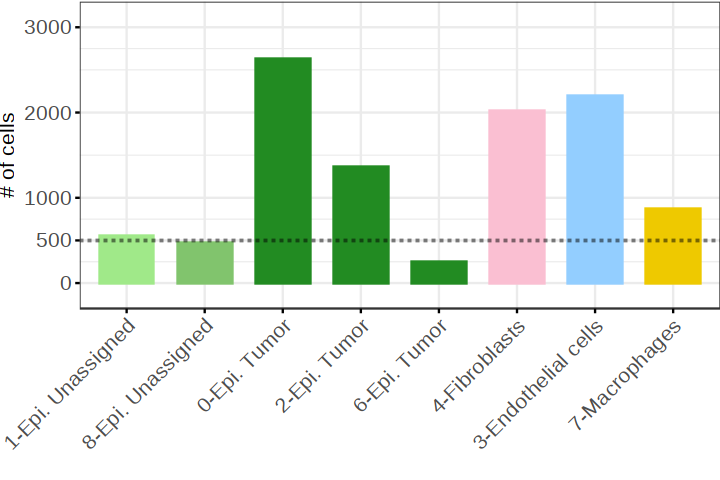

In [9]:
str_title <- "ncells"

gg <- print_ggpubr(atac,
            x = col_cluster_types, y = "cnt",
            color = col_cluster_types, 
            fill = col_cluster_types, 
            order_x = names(nv_colors),
            facet.by = NULL, facet.ncol = 1,
            plot_type = "barplot",
            color_manual = nv_colors, fill_manual = nv_colors,
            ylimits = c(0, 3000),
            ybreaks = c(500, pretty(c(0, 3000), n = 3)),
            yexpand = c(0.1, 0.1),
            yintercept = 500,
            xlim = NULL, ylim = NULL,
            xlab = "", ylab = "# of cells",
            angle = 45, font_size = 12,
            width = 6, height = 4,
            str_condition_plot = sprintf("cluster_type_%s_atac", str_title),
            n_log = 0)


# nFrags

## barplot

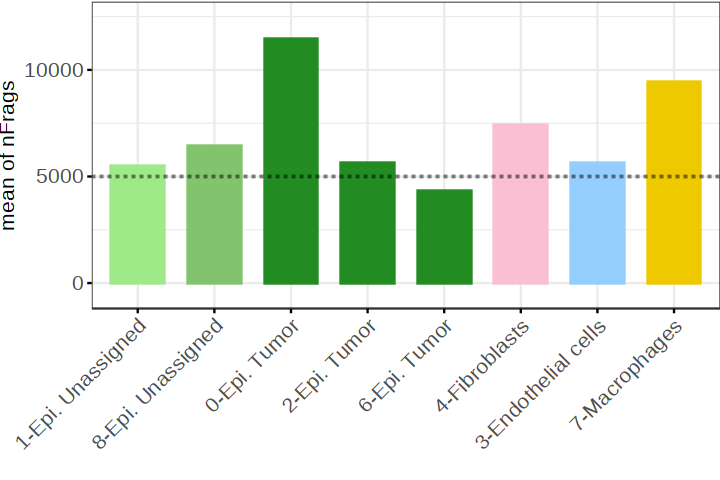

In [10]:
str_title <- "mean_of_nfrags"

gg <- print_ggpubr(atac,
            x = col_cluster_types, y = "nFrags",
            color = col_cluster_types, 
            fill = col_cluster_types, 
            order_x = names(nv_colors),
            facet.by = NULL, facet.ncol = 1,
            plot_type = "barplot",
            color_manual = nv_colors, fill_manual = nv_colors,
            ylimits = c(0, 12000),
            ybreaks = pretty(c(0, 10000), n = 3),
            yexpand = c(0.1, 0.1),
            yintercept = 5000,
            xlim = NULL, ylim = NULL,
            xlab = "", ylab = "mean of nFrags",
            angle = 45, font_size = 12,
            width = 6, height = 4,
            str_condition_plot = sprintf("cluster_type_%s", str_title),
            n_log = 0)




# TSSEnrichment score

## barplot

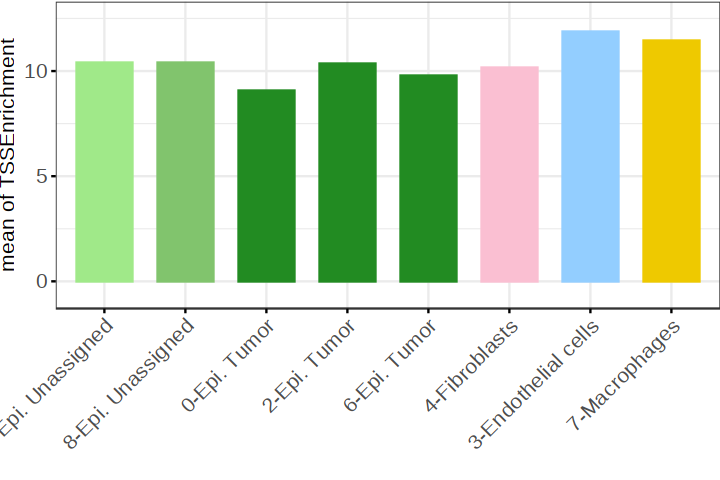

In [11]:
str_title <- "mean_of_tssenrichment"

gg <- print_ggpubr(atac,
            x = col_cluster_types, y = "TSSEnrichment",
            color = col_cluster_types, 
            fill = col_cluster_types, 
            order_x = names(nv_colors),
            facet.by = NULL, facet.ncol = 1,
            plot_type = "barplot",
            color_manual = nv_colors, fill_manual = nv_colors,
            ylimits = c(0, 12),
            ybreaks = pretty(c(0, 12), n = 3),
            yexpand = c(0.1, 0.1),
            #yintercept = 4,
            xlim = NULL, ylim = NULL,
            xlab = "", ylab = "mean of TSSEnrichment",
            angle = 45, font_size = 12,
            width = 6, height = 4,
            str_condition_plot = sprintf("cluster_type_%s", str_title),
            n_log = 0)

